### Selected channels: 7,8,9,12



In [1]:
from EEGModels import EEGNet
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import os
import scipy
import numpy as np
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from IPython.display import display, HTML


In [2]:
%run "../../functions/bandpass.ipynb"
%run "../../functions/get_data.ipynb"
%run "../../functions/trimmer.ipynb"
%run "../../functions/training.ipynb"

# DATA PREPROCESSING AND FILTERING

In [3]:
folder_path = '../../data/initial_data/walk_inst_raw/'
file_list = get_file_list(folder_path)

print(file_list)

['../../data/initial_data/walk_inst_raw/P_1.mat', '../../data/initial_data/walk_inst_raw/P_10.mat', '../../data/initial_data/walk_inst_raw/P_2.mat', '../../data/initial_data/walk_inst_raw/P_3.mat', '../../data/initial_data/walk_inst_raw/P_4.mat', '../../data/initial_data/walk_inst_raw/P_5.mat', '../../data/initial_data/walk_inst_raw/P_9.mat', '../../data/initial_data/walk_inst_raw/S_1.mat', '../../data/initial_data/walk_inst_raw/S_10.mat', '../../data/initial_data/walk_inst_raw/S_2.mat', '../../data/initial_data/walk_inst_raw/S_3.mat', '../../data/initial_data/walk_inst_raw/S_4.mat', '../../data/initial_data/walk_inst_raw/S_5.mat', '../../data/initial_data/walk_inst_raw/S_9.mat']


In [4]:
discontinuous_files, total_found = get_discontinuous_files(file_list)

(56, 14, 750)
(37, 14, 750)
(49, 14, 750)
(56, 14, 750)
(58, 14, 750)
(57, 14, 750)
(60, 14, 750)
(60, 14, 750)
[(4, 0, 375), (5, 0, 397), (11, 0, 486), (14, 0, 591), (15, 5, 674), (34, 0, 122), (37, 0, 51), (45, 0, 657)]
(67, 14, 750)
(60, 14, 750)
[(16, 0, 618)]
(80, 14, 750)
[(21, 0, 387), (49, 0, 681), (73, 0, 219), (75, 0, 24)]
(79, 14, 750)
[(62, 0, 240)]
(66, 14, 750)
(84, 14, 750)
[(34, 0, 37)]


In [5]:
X, Y = trim_discontinuous_files(file_list, discontinuous_files, total_found)

In [6]:
print(discontinuous_files)
print(total_found)

[('../../data/initial_data/walk_inst_raw/S_1.mat', [(4, 0, 375), (5, 0, 397), (11, 0, 486), (14, 0, 591), (15, 5, 674), (34, 0, 122), (37, 0, 51), (45, 0, 657)]), ('../../data/initial_data/walk_inst_raw/S_2.mat', [(16, 0, 618)]), ('../../data/initial_data/walk_inst_raw/S_3.mat', [(21, 0, 387), (49, 0, 681), (73, 0, 219), (75, 0, 24)]), ('../../data/initial_data/walk_inst_raw/S_4.mat', [(62, 0, 240)]), ('../../data/initial_data/walk_inst_raw/S_9.mat', [(34, 0, 37)])]
15


In [7]:
kick_out = [(1, [19, 30]), (2, [3, 5, 32, 46]), (3, [14, 39]), (4, [13, 22, 37, 45]), (5, [17]), (7, [13, 31, 37, 49]),
            (8, [54]), (9, [0, 8, 12, 15, 39, 40, 44, 45, 50, 55, 57]), (10, [2, 16, 20, 23, 46, 47, 56, 60]), (11, [37, 51, 67, 73, 74]), 
            (12, [2, 27, 54]), (13, [26, 34, 38, 41, 52, 59, 68])]


file_dict = {0: 'P_1', 1: 'P_10', 2: 'P_2', 3: 'P_3', 4: 'P_4', 5: 'P_5', 6: 'P_9', 7: 'S_1', 8: 'S_10', 
             9: 'S_2', 10: 'S_3', 11: 'S_4', 12: 'S_5', 13: 'S_9'}

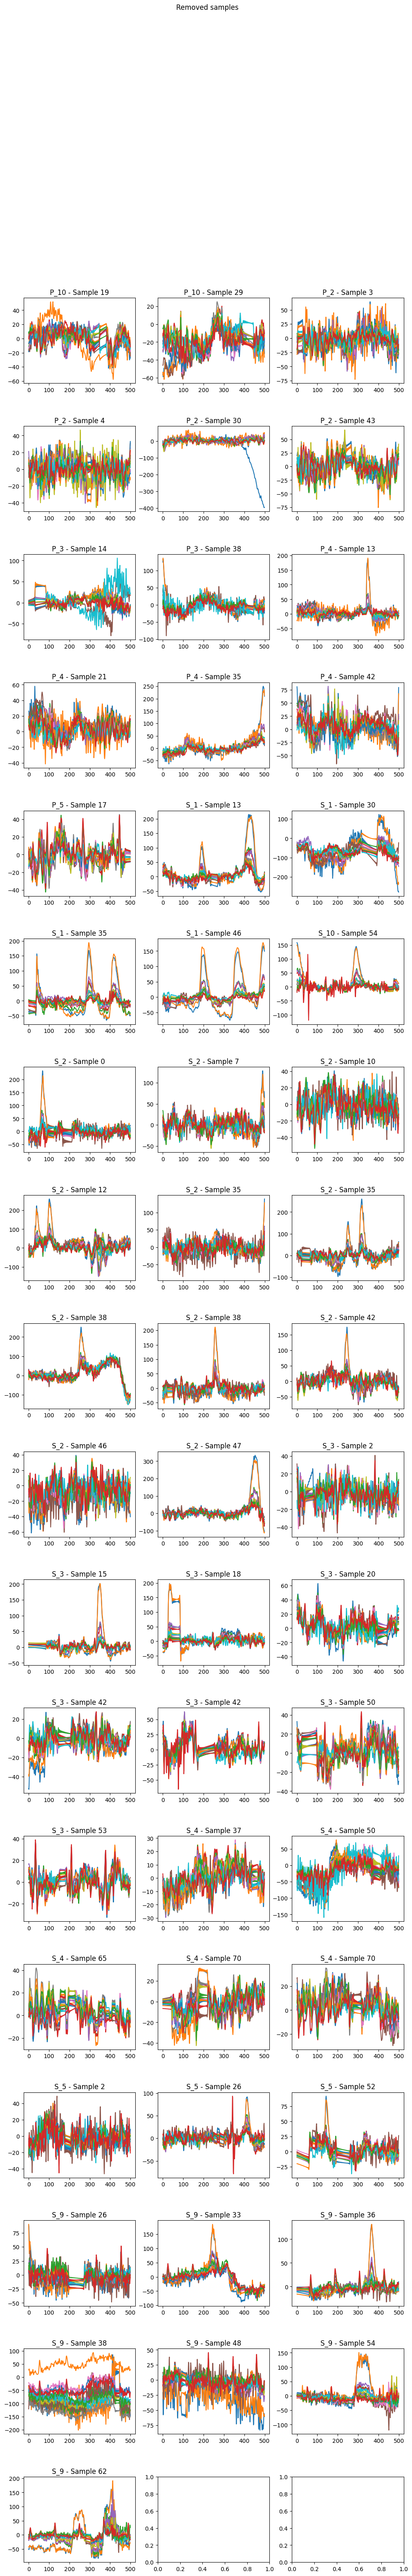

In [8]:
new_X, new_Y = trim_manually(kick_out, X, Y, file_dict, print_out=True)

In [9]:
print_eliminations(file_list, new_X, new_Y, print_shape=True)

(56, 14, 750) -> (56, 14, 500) (56, 2)
(37, 14, 750) -> (35, 14, 500) (35, 2)
(49, 14, 750) -> (45, 14, 500) (45, 2)
(56, 14, 750) -> (54, 14, 500) (54, 2)
(58, 14, 750) -> (54, 14, 500) (54, 2)
(57, 14, 750) -> (56, 14, 500) (56, 2)
(60, 14, 750) -> (60, 14, 500) (60, 2)
(60, 14, 750) -> (48, 14, 500) (48, 2)
(67, 14, 750) -> (66, 14, 500) (66, 2)
(60, 14, 750) -> (48, 14, 500) (48, 2)
(80, 14, 750) -> (68, 14, 500) (68, 2)
(79, 14, 750) -> (73, 14, 500) (73, 2)
(66, 14, 750) -> (63, 14, 500) (63, 2)
(84, 14, 750) -> (76, 14, 500) (76, 2)
Total samples removed:  67
Total samples remaining:  802


In [10]:
desired_channels = [6, 7, 8, 11]
for i in range(len(new_X)):
    new_X[i] = new_X[i][:, desired_channels, :]

In [11]:
print_eliminations(file_list, new_X, new_Y)

Total samples removed:  67
Total samples remaining:  802


# TRAINING ON THE FILTERED DATA

In [12]:
scroll_style = """
<style>
.output {
    overflow-y: scroll;
    max-height: 300px; /* Adjust the height as per your preference */
}
</style>
"""

In [13]:
kernels, chans, samples = 1, 4, 500

In [ ]:
display(HTML(scroll_style))
acc, p_acc, s_acc = train(kernels, samples, chans, new_X, new_Y, "../results/walk_instr_raw.txt", epochs = 50)
print_results(p_acc, s_acc, acc, "../results/walk_instr_raw.txt")